# SemiConductor Stock Market Analysis 

Use LSTM to collect and predict future stock prices

Introduction of other factors to the stock analysis process

Stock market prediction based on the performance of other stocks in the market in the same category

Depending on the perforamnce of other stocks such as Nvidia, AMD, etc. then the output should change

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, LSTM

# yf.pdr_override() # deprecated

# Stock Prediction with LSTM 

Use just the stock's closing price to predict the next opening price

In [26]:
# Define the stock symbol and date range
stock_symbol = 'NVDA'
end = datetime.now()
start = datetime(end.year - 5, end.month, end.day)

# Fetch data for the stock
df = yf.download(stock_symbol, start=start, end=end)

# Flatten the column MultiIndex
df.columns = [col[0] for col in df.columns]  # Keep only the first level of the header

# makes Close accessible by removed the other header level
data = df.filter(['Close'])

# Convert to numpy array
dataset = data.values


[*********************100%***********************]  1 of 1 completed


In [27]:
df.head()

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2019-12-03,5.170182,5.19150,5.19550,5.00925,5.04675,465232000
2019-12-04,5.214003,5.23550,5.29800,5.20675,5.27550,273424000
2019-12-05,5.197072,5.21850,5.27325,5.18775,5.25750,184884000
2019-12-06,5.282469,5.30425,5.33725,5.27800,5.28800,232236000
2019-12-09,5.282469,5.30425,5.35925,5.27250,5.28125,211880000


In [28]:
def preprocess_data(stock_symbol, epochs=100, batch_size=32, window_size=60):
    # Fetch data
    end = datetime.now()
    start = datetime(end.year - 5, end.month, end.day)

    # Fetch data for multiple stocks for the last 5 years
    df = yf.download(stock_symbol, start=start, end=end)

    # Flatten the column MultiIndex
    df.columns = [col[0] for col in df.columns]  # Keep only the first level of the header

    # Now, 'Close' will be accessible directly
    data = df.filter(['Close'])

    # Convert to numpy array
    dataset = data.values

    # split training data
    training_data_len = int(np.ceil(len(dataset) * .95))

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(dataset)

    X, y = [], []
    for i in range(len(scaled_data) - window_size):
        X.append(scaled_data[i:i+window_size])
        y.append(scaled_data[i+window_size])

    X, y = np.array(X), np.array(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse')

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)

    # Make predictions
    test_data = scaled_data[training_data_len - window_size:, :]
    test_set = []
    for i in range(window_size, len(test_data)):
        test_set.append(test_data[i-window_size:i, 0])

    test_set = np.array(test_set)
    test_set = np.reshape(test_set, (test_set.shape[0], test_set.shape[1], 1))

    prediction = model.predict(test_set)
    scaled_pred = scaler.inverse_transform(prediction)

    # Prepare results
    valid = data[training_data_len:]
    valid['Predictions'] = scaled_pred

    return df, valid, scaled_pred

In [29]:
df_nvda_5, valid_nvda, pred_nvda = preprocess_data('NVDA')

[*********************100%***********************]  1 of 1 completed


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002938ADAB380> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 370ms/step


In [30]:
valid_nvda

,Close,Predictions
Date,,
2024-09-06,102.830002,111.010132
2024-09-09,106.470001,107.872368
2024-09-10,108.099998,109.574326
2024-09-11,116.910004,111.398170
2024-09-12,119.139999,118.597862
...,...,...
2024-11-26,136.919998,138.554062
2024-11-27,135.339996,138.980896
2024-11-29,138.250000,138.137100


In [31]:
r2 = r2_score(valid_nvda['Close'], valid_nvda['Predictions'])
print(f'R2 Score: {r2}')

R2 Score: 0.8799746927407388


In [32]:
current_price = df_nvda_5['Close'].iloc[-1]
threshold = 0.03

# predicted_price = float(pred_nvda[-1])
predicted_price = valid_nvda['Predictions'].iloc[-1]

# Decision logic
price_change = (predicted_price - current_price) / current_price  # Calculate % change
if price_change > threshold:
    action = "Buy"
elif price_change < -threshold:
    action = "Sell"
else:
    action = "Hold"

# Print the decision
print(f"Predicted Price: ${predicted_price:.2f}")
print(f"Current Price: ${current_price:.2f}")
print(f"Price Change: {price_change:.2%}")
print(f"Decision: {action}")

Predicted Price: $141.49
Current Price: $140.26
Price Change: 0.87%
Decision: Hold


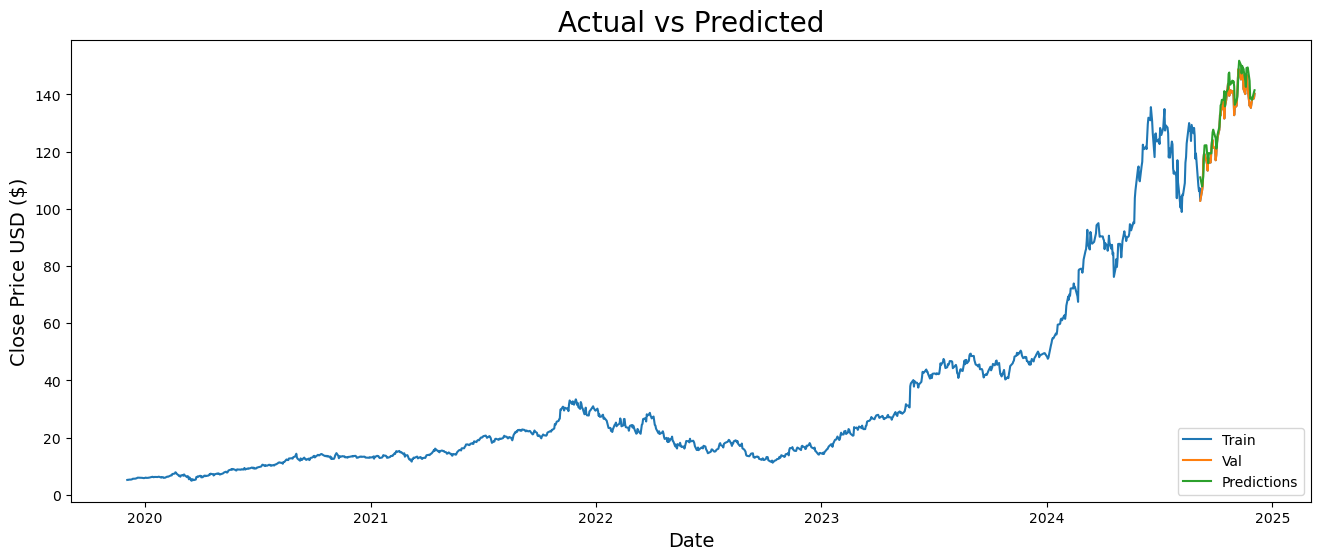

In [33]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Actual vs Predicted', fontsize=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price USD ($)', fontsize=14)
plt.plot(df_nvda_5['Close'])
plt.plot(valid_nvda[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

# Stock Prediction using influence of other Stocks in LSTM

Modify model to take predictions of last relevant stocks to influence price calculation

In [34]:
# use the Nasdaq index as a macroeconomic indicator

# stock prediction focuses semiconductor stocks

# semiconductor stocks
# nvidia, taiwan semiconductor manufacturing, broadcom, qualcomm, AMD

# 5 years
stock_list = ['NVDA','TSM', 'AVGO', 'QCOM', 'AMD']

target_symbol = 'NVDA'

In [35]:
# Fetch data for multiple stocks for 5 years
end = datetime.now()
start = datetime(end.year - 5, end.month, end.day)

# Fetch data for multiple stocks for the last 5 years
data = yf.download(stock_list, start=start, end=end)

# data.head()

stock_data = data['Close']

[*********************100%***********************]  5 of 5 completed


In [36]:
# Separate the target stock (NVDA) and other stocks
target_data = stock_data[target_symbol]  # The target stock data (NVDA)
other_stocks_data = stock_data.drop(columns=[target_symbol])  # All other stocks

# Combine the data: We want the target stock's history based on all other stocks
dataset = pd.concat([other_stocks_data, target_data], axis=1).values

In [37]:
# Calculate the length for training data
training_data_len = int(np.ceil(len(dataset) * .95))

# Scale the data using MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(dataset)

In [38]:
window_size = 60 # number of days to consider

# Prepare the feature (X) and target (y) sequences
X, y = [], []
for i in range(len(scaled_data) - window_size):
    X.append(scaled_data[i:i+window_size, :-1])  # All stock data for the window, excluding target stock
    y.append(scaled_data[i+window_size, -1])  # Target stock's next day close price, the last column


# Convert the lists into numpy arrays
X, y = np.array(X), np.array(y)

In [39]:
# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
# Build the LSTM model

# input shape (samples, timesteps, features)
# samples = number of data points
# timesteps = length of each sequence
# features = number of variables/features observed at each step

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')


In [41]:
epochs = 100
batch_size = 32

# Train the model
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=0)

In [42]:
# Make predictions
test_data = scaled_data[training_data_len - window_size:, :]
test_set = []
for i in range(window_size, len(test_data)):
    test_set.append(test_data[i - window_size:i, :-1])  # Use the history of other stocks

test_set = np.array(test_set)
test_set = np.reshape(test_set, (test_set.shape[0], test_set.shape[1], test_set.shape[2]))

In [43]:
# Prediction
prediction = model.predict(test_set)

# Reshape the prediction to (num_samples, 1) for inverse transformation
prediction = prediction.reshape(-1, 1)  # Flatten the output for inverse transformation

# Inverse transform the predictions for the target stock (the last column)
scaled_pred = scaler.inverse_transform(np.hstack([np.zeros((prediction.shape[0], scaled_data.shape[1] - 1)), prediction]))

# Prepare results for the target stock
valid = target_data[training_data_len:]
valid = valid.to_frame()  # Convert to DataFrame, in the case the data is a series
valid['Predictions'] = scaled_pred[:, -1]  # Only take the last column for the target stock

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step


In [44]:
valid.head()

,NVDA,Predictions
Date,,
2024-09-06,102.830002,120.065531
2024-09-09,106.470001,116.841638
2024-09-10,108.099998,115.418244
2024-09-11,116.910004,115.430583
2024-09-12,119.139999,117.419827


In [45]:
r2 = r2_score(valid['NVDA'], valid['Predictions'])
print(f'R2 Score: {r2}')

R2 Score: 0.6292094683676669


Observations: 
Makes predictions for the target stock in the past 5 years and use of other stocks to compare prices and adjust final prediction. R2 score would indicate that the model is fairly accurate in predicting the target stock's price. However, it's important to note that this model doesn't take into account other factors such as news, only comparing and measuring prices of other stocks to adjust its final decision.

In [46]:
# Extract the last prediction as a scalar value
predicted_price = valid['Predictions'].iloc[-1]

# Get the current price (last adjusted close price)
current_price = data['Close']['NVDA'].iloc[-1]

# Define the threshold
threshold = 0.03 

# Decision logic
price_change = (predicted_price - current_price) / current_price  # Calculate % change
if price_change > threshold:
    action = "Buy"
elif price_change < -threshold:
    action = "Sell"
else:
    action = "Hold"

# Print the decision
print(f"Predicted Price: ${predicted_price:.2f}")
print(f"Current Price: ${current_price:.2f}")
print(f"Price Change: {price_change:.2%}")
print(f"Decision: {action}")


Predicted Price: $145.87
Current Price: $140.26
Price Change: 4.00%
Decision: Buy


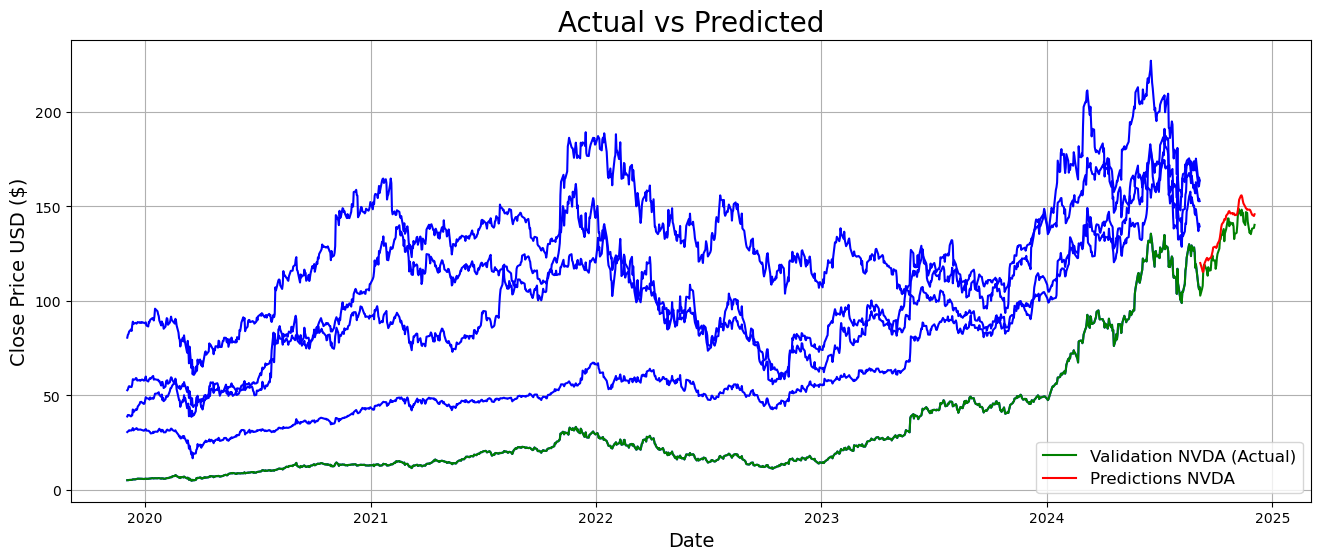

In [47]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Actual vs Predicted', fontsize=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Close Price USD ($)', fontsize=14)

plt.plot(data[:training_data_len]['Close'], color='blue')
plt.plot(data['Close']['NVDA'], label='Validation NVDA (Actual)', color='green')
plt.plot(valid['Predictions'], label='Predictions NVDA', color='red')
plt.legend(loc='lower right', fontsize=12)
plt.grid(True)
plt.show()